In [186]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from train_set import Training_set, train_df
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std


## Split the combined dataframe into features and labels, and split it in training and test set

In [98]:
X = Training_set.iloc[:, :-1]
#Y has the last col with labels
y = Training_set.iloc[:, -1]

# split the dataset to train and test, the 2nd is for the non feature selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# logistic regression needs the data scaled
scaler = StandardScaler().fit(X_train)
scaler
StandardScaler()

X_scaled = scaler.transform(X_train)

## Feature selection with RFECV

In [99]:
# feature selection using RFECV with logistic regression estimator
clf1 = LogisticRegression()
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=clf1,
    step=1,
    cv=cv_inner,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X_scaled, y_train)


print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 11


In [105]:

# Get selected features from RFECV and make a new dataframe with only this information
selected_features = X_train.loc[:, rfecv.support_]
selected_features.to_csv("RFE_dataset.csv")

## Nested Cross validation for parameter tuning

In [192]:
# Split the generated data into training and testing sets
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
actual_scores = []

# Define the parameter grid for the random forest classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

for train_index_inner, test_index_inner in skf_outer.split(selected_features, y_train):
    X_train_inner, X_test_inner = selected_features.iloc[train_index_inner], selected_features.iloc[test_index_inner]
    y_train_inner, y_test_inner = y_train.iloc[train_index_inner], y_train.iloc[test_index_inner]

    # parameter tuning for the random forest classifier using GridSearchCV
    rf_model = RandomForestClassifier(random_state=42)

    # Inner cross-validation loop for hyperparameter tuning
    skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', cv=skf_inner)

    grid_search.fit(X_train_inner, y_train_inner)
    best_model = grid_search.best_estimator_
    yhat = best_model.predict(X_test_inner)
    acc= accuracy_score(y_test_inner,yhat)
    actual_scores.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, grid_search.best_score_, grid_search.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(actual_scores), std(actual_scores)))

>acc=0.812, est=0.954, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
>acc=0.875, est=0.923, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.812, est=0.858, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
>acc=1.000, est=0.908, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
>acc=0.875, est=0.873, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.875 (0.068)


## Automated CV for parameter tuning

>acc=0.812, est=0.954, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
>acc=0.875, est=0.923, cfg={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.812, est=0.858, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
>acc=1.000, est=0.908, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
>acc=0.875, est=0.873, cfg={'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.875 (0.068)

 ## Print the mean accuracy and standard deviation of the validation sets

## Build final classifier with the best hyperparameters and find the accuracy - i will use the ones that came out with the best scoring

In [196]:
clf_final =  RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=5, min_samples_leaf=1)

clf_final.fit(selected_features, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5)

In [199]:
# Evaluate the trained classifier on the test set
selected_features_test_final = X_test.loc[:, rfecv.support_]
y_pred_final = clf_final.predict(selected_features_test_final)
score_total = accuracy_score(y_test, y_pred_final)
precision = metrics.precision_score(y_test, y_pred_final, average='macro')
recall = metrics.recall_score(y_test, y_pred_final, average='macro')
f1_score = metrics.f1_score(y_test, y_pred_final, average='macro')


In [200]:
print(" Accuracy: {:.2f}%".format(score_total * 100))
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')


 Accuracy: 85.00%
Precision: 0.900
Recall: 0.833
F1-score: 0.830


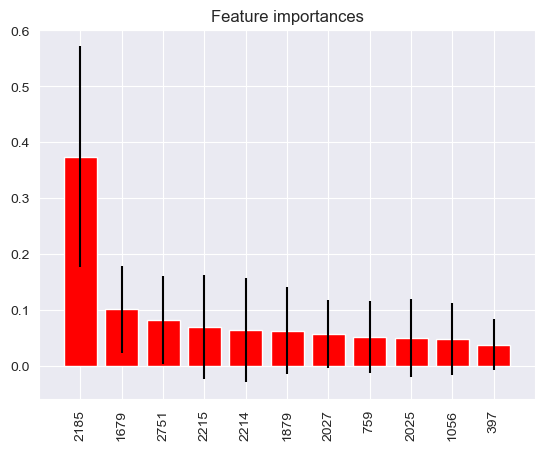

In [201]:
importances = clf_final.feature_importances_
n= 18
indices = importances.argsort()[::-1][:n]
# Visualize the feature importances
std = np.std([tree.feature_importances_ for tree in clf_final.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(selected_features.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(selected_features.shape[1]), selected_features.columns[indices], rotation=90)
plt.xlim([-1, selected_features.shape[1]])
plt.show()


<Axes: >

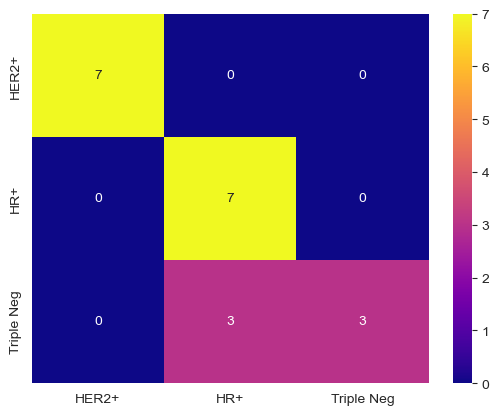

In [202]:
cm = confusion_matrix(y_test, y_pred_final)
labels = ["HER2+", "HR+", "Triple Neg"]
sns.heatmap(cm, annot=True, cmap="plasma", fmt="d", xticklabels=labels, yticklabels=labels)

In [206]:
# Create a classification report
cr = classification_report(y_test, y_pred_final)
print(cr)


              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         7
         HR+       0.70      1.00      0.82         7
  Triple Neg       1.00      0.50      0.67         6

    accuracy                           0.85        20
   macro avg       0.90      0.83      0.83        20
weighted avg       0.89      0.85      0.84        20



## Export to pkl

In [205]:
import pickle
pickle.dump(clf_final, open('rfe-rf.pkl', 'wb'))